# Непрерывные переменные

В отличие от пропорций, у непрерывных переменных нам не известен тип распределения, а значит и неизвестно как именно нужно расчитывать размер выборки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind


ayu_colors = {
    "axes.facecolor": "#1F2430",  # фон графика
    "figure.facecolor": "#1F2430",  # фон фигуры
    "text.color": "#CBCCC6",  # цвет текста
    "axes.labelcolor": "#CBCCC6",  # цвет подписей осей
    "xtick.color": "#707A8C",  # цвет делений оси X
    "ytick.color": "#707A8C",  # цвет делений оси Y
    "grid.color": "#232834",  # цвет сетки
    "axes.prop_cycle": plt.cycler(
        color=["#8dd3c7", "#feffb3", "#bfbbd9", "#fa8174", "#81b1d2"]
    ),  # цвета линий как в dark_background
}

plt.rcParams.update(ayu_colors)

## Нормальное распределение и применение t-test:

<Axes: >

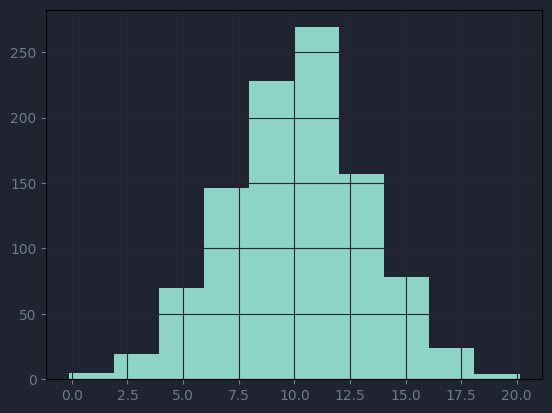

In [3]:
pd.Series(np.random.normal(10, 3, size=1000)).hist()

<Axes: >

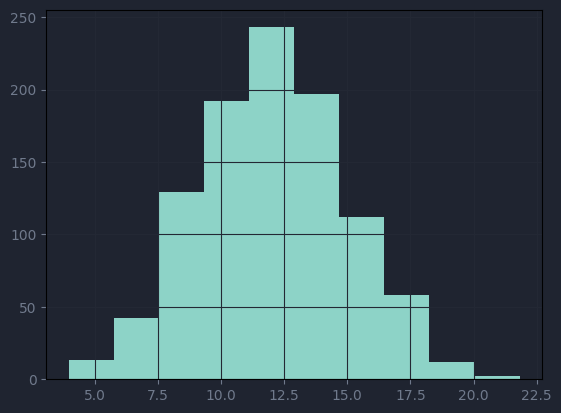

In [4]:
pd.Series(np.random.normal(12, 3, size=1000)).hist()

In [5]:
baseline = 10
mde = 2
result = []
n = 1000
sample_size = 36

for _ in range(n):
    a = np.random.normal(baseline, 3, size=sample_size)
    b = np.random.normal(baseline + mde, 3, size=sample_size)
    _, pval = ttest_ind(a, b, equal_var=False)
    result.append(pval)

t = pd.Series(result)

In [6]:
(t < 0.05).mean()

np.float64(0.793)

Как проверить, что можно применять t test для наших данных:
- Выборочное среднее распределено нормально - bootstrap + qq plot
- p-value для выборок из одного распределения(aa test) имеет равномерное распределение(uniform) - bootstrap + qq plot
- теоретичесмкий false positive == практическому false positive

### 1. Выборочное среднее распределено нормально - bootstrap + qq plot:

<Axes: >

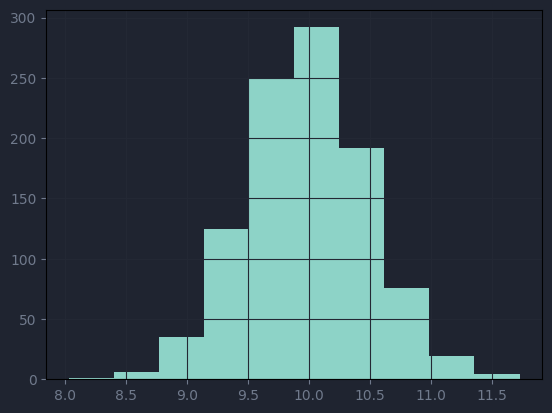

In [7]:
t = pd.Series([np.random.normal(10, 3, size=36).mean() for _ in range(1000)])
t.hist()

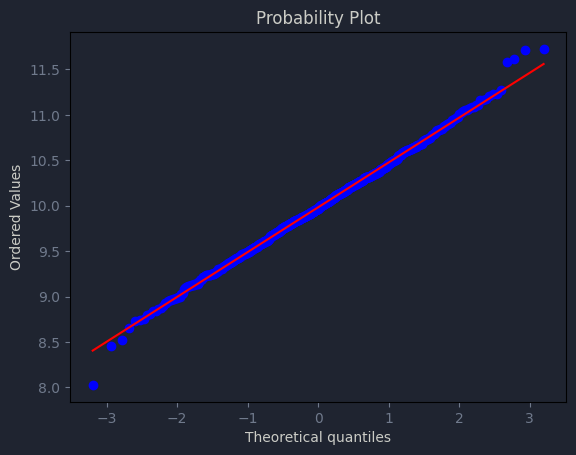

In [8]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

### 2. p-value для выборок из одного распределения(aa test) имеет равномерное распределение(uniform) - bootstrap + qq plot

In [9]:
baseline = 10
result = []
n = 1000
sample_size = 36

for _ in range(n):
    a = np.random.normal(baseline, 3, size=sample_size)
    a1 = np.random.normal(baseline, 3, size=sample_size)
    _, pval = ttest_ind(a, a1, equal_var=False)
    result.append(pval)

t = pd.Series(result)

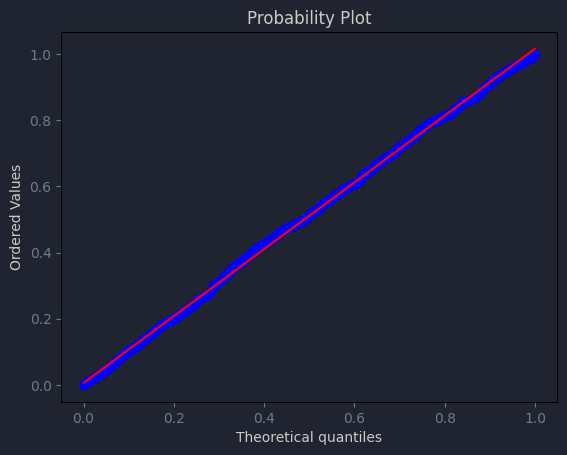

In [10]:
stats.probplot(t, dist="uniform", plot=pylab)
pylab.show()

### 3. Теоретичесмкий false positive == практическому false positive:

In [11]:
(t < 0.05).mean()

np.float64(0.055)

### Расчет мощности для t-теста

У нас есть только выборка. Для того, чтобы расчитать eefect_size для формулы, необходимо узнать mde и std для нашей выборки:

In [12]:
std = float(pd.Series(np.random.normal(baseline, 3, size=1000)).std())

параметр effect_size - standardized effect size, difference between the two means divided by the standart deviation. Must be positive number

In [13]:
import statsmodels.stats.api as sms

effect_size = (12 - 10) / std

sms.TTestIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)

37.781255079470576

## Ненормальное распределение:

В случае ненормального распределения, применение t-test будет нецелесообразным, поскольку распределение средних будет смещенным, например для логнормального распределения

In [14]:
a = np.random.lognormal(mean=5, sigma=2, size=(100000,))
b = np.random.lognormal(mean=5.04, sigma=2, size=(100000,))

<Axes: >

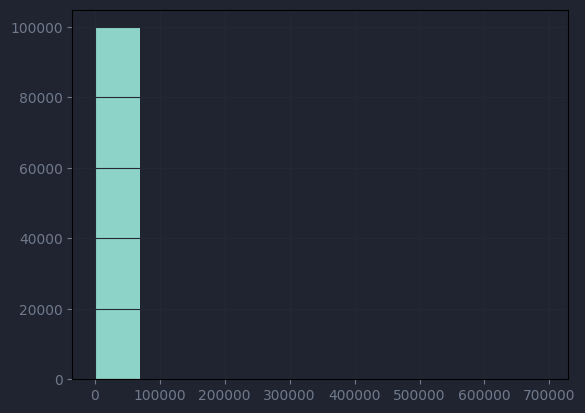

In [15]:
pd.Series(a).hist()

In [16]:
t = pd.Series(
    [
        np.random.lognormal(mean=5, sigma=2, size=(100000,)).mean()
        for _ in tqdm(range(1000))
    ]
)

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: >

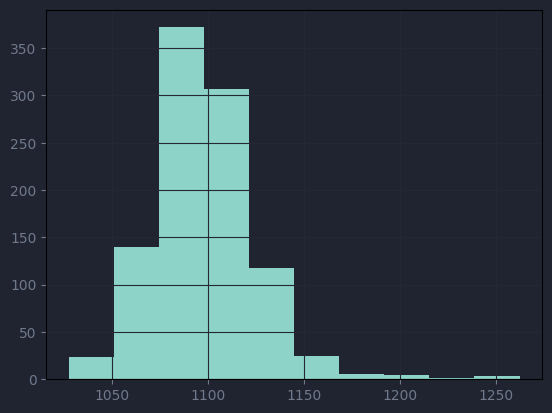

In [17]:
t.hist()

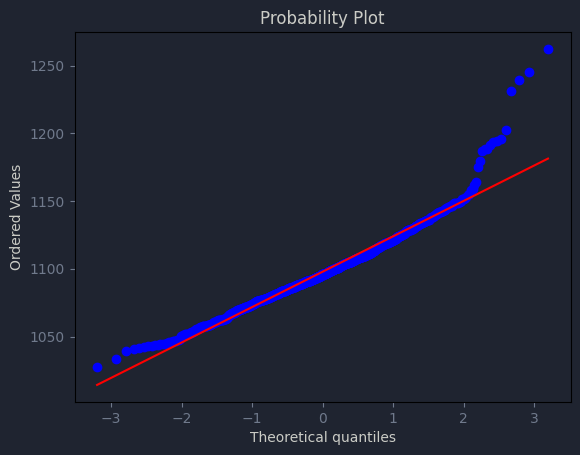

In [18]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

В данном случае критерий для проведения t-test уже нарушается, поскольку средние распределены ненормально

In [19]:
result = []
n = 1000

for _ in tqdm(range(n)):
    a = np.random.lognormal(mean=5, sigma=2, size=(100000,))
    a1 = np.random.lognormal(mean=5, sigma=2, size=(100000,))
    _, pval = ttest_ind(a, a1, equal_var=False)
    result.append(pval)

t = pd.Series(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: >

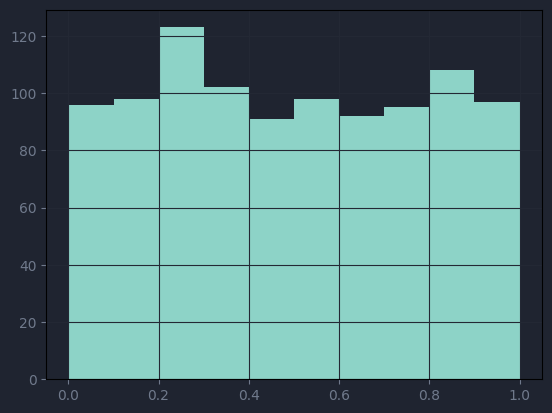

In [20]:
t.hist()

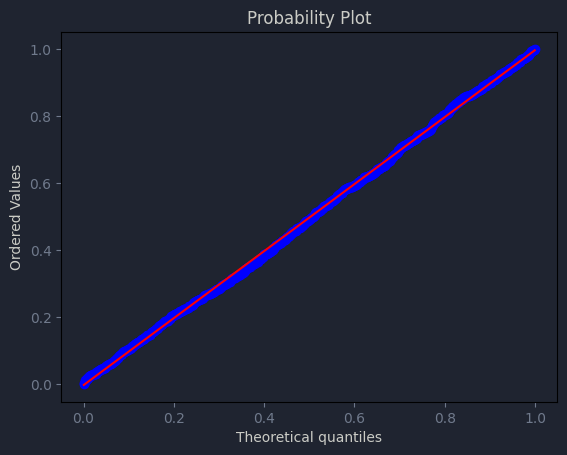

In [21]:
stats.probplot(t, dist="uniform", plot=pylab)
pylab.show()

In [22]:
(t < 0.05).mean()

np.float64(0.047)

Кажется, что t-test можно проводить, но посмотрим на мощность теста:

In [23]:
result = []
n = 1000

for _ in tqdm(range(n)):
    a = np.random.lognormal(mean=5, sigma=2, size=(100000,))
    b = np.random.lognormal(mean=5.04, sigma=2, size=(100000,))
    _, pval = ttest_ind(a, b, equal_var=False)
    result.append(pval)

t = pd.Series(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
print(
    f"Мощность t-test'a для логнормального распределения равна {(t < 0.05).mean():0.3f}"
)

Мощность t-test'a для логнормального распределения равна 0.274


Для проведения этого теста необходимо набирать большую выборку. Попробуем расчитать размер выборки для проведения t-test'a при логнормальном распределении. Прикинем среднее для выборок с помощью bootstrap:

In [25]:
a_mean_bs = pd.Series(
    [
        np.random.lognormal(mean=5, sigma=2, size=(100000,)).mean()
        for _ in tqdm(range(1000))
    ]
).mean()
a_mean_bs

  0%|          | 0/1000 [00:00<?, ?it/s]

np.float64(1096.3329780506522)

In [26]:
b_mean_bs = pd.Series(
    [
        np.random.lognormal(mean=5.04, sigma=2, size=(100000,)).mean()
        for _ in tqdm(range(1000))
    ]
).mean()
b_mean_bs

  0%|          | 0/1000 [00:00<?, ?it/s]

np.float64(1140.6548481260618)

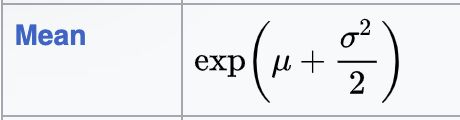

In [27]:
a_mean_teor = np.exp(5 + pow(2, 2) / 2)
b_mean_teor = np.exp(5.04 + pow(2, 2) / 2)
print(a_mean_teor, b_mean_teor)

1096.6331584284585 1141.387606628968


In [28]:
effect_size = (b_mean_teor - a_mean_teor) / a.std()

sms.TTestIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)

363089.91796135023

In [29]:
t = pd.Series(
    [
        np.random.lognormal(mean=5, sigma=2, size=(416981,)).mean()
        for _ in tqdm(range(1000))
    ]
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [30]:
result = []
n = 1000

for _ in tqdm(range(n)):
    a = np.random.lognormal(mean=5, sigma=2, size=(416981,))
    b = np.random.lognormal(mean=5.04, sigma=2, size=(416981,))
    _, pval = ttest_ind(a, b, equal_var=False)
    result.append(pval)

t = pd.Series(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
print(
    f"Мощность t-test'a для логнормального распределения равна {(t < 0.05).mean():0.3f}"
)

Мощность t-test'a для логнормального распределения равна 0.730


Поэтому, дли применения рассчета размера выборки прологарифмируем наши данные, чтобы привести их к нормальному распределению:

In [32]:
result = []
n = 1000

for _ in tqdm(range(n)):
    a = np.log(np.random.lognormal(mean=5, sigma=2, size=(100000,)))
    b = np.log(np.random.lognormal(mean=5.04, sigma=2, size=(100000,)))
    _, pval = ttest_ind(a, b, equal_var=False)
    result.append(pval)

t = pd.Series(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
(t < 0.05).mean()

np.float64(0.991)

In [34]:
a = np.random.lognormal(mean=5, sigma=2, size=(100000,))

In [35]:
effect_size = (np.log(b_mean_teor) - np.log(a_mean_teor)) / np.log(a).std()

sms.TTestIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)

39359.01778304667

In [36]:
result = []
n = 1000

for _ in tqdm(range(n)):
    a = np.log(np.random.lognormal(mean=5, sigma=2, size=(39441,)))
    b = np.log(np.random.lognormal(mean=5.04, sigma=2, size=(39441,)))
    _, pval = ttest_ind(a, b, equal_var=False)
    result.append(pval)

t = pd.Series(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [37]:
(t < 0.05).mean()

np.float64(0.799)

In [38]:
np.exp(b.mean() - a.mean())

np.float64(1.0400023179006588)

### Что если неизвестен тип распределения, который у нас есть?

Для этого есть функция со stackoverflow:

In [39]:
lognormal_dist = pd.Series(np.random.lognormal(mean=5, sigma=2, size=(39441,)))

  1 / 110: ksone
  2 / 110: kstwo
  3 / 110: kstwobign
  4 / 110: norm
  5 / 110: alpha
  6 / 110: anglit
  7 / 110: arcsine
  8 / 110: beta
  9 / 110: betaprime
 10 / 110: bradford
 11 / 110: burr
 12 / 110: burr12
 13 / 110: fisk
 14 / 110: cauchy
 15 / 110: chi
 16 / 110: chi2
 17 / 110: cosine
 18 / 110: dgamma
 19 / 110: dpareto_lognorm
 20 / 110: dweibull
 21 / 110: expon
 22 / 110: exponnorm
 23 / 110: exponweib
 24 / 110: exponpow
 25 / 110: fatiguelife
 26 / 110: foldcauchy
 27 / 110: f
 28 / 110: foldnorm
 29 / 110: weibull_min
 30 / 110: truncweibull_min
 31 / 110: weibull_max
 32 / 110: genlogistic
 33 / 110: genpareto
 34 / 110: genexpon
 35 / 110: genextreme
 36 / 110: gamma
 37 / 110: erlang
 38 / 110: gengamma
 39 / 110: genhalflogistic
 40 / 110: genhyperbolic
 41 / 110: gompertz
 42 / 110: gumbel_r
 43 / 110: gumbel_l
 44 / 110: halfcauchy
 45 / 110: halflogistic
 46 / 110: halfnorm
 47 / 110: hypsecant
 48 / 110: gausshyper
 49 / 110: invgamma
 50 / 110: invgauss
 51

Text(0, 0.5, 'Frequency')

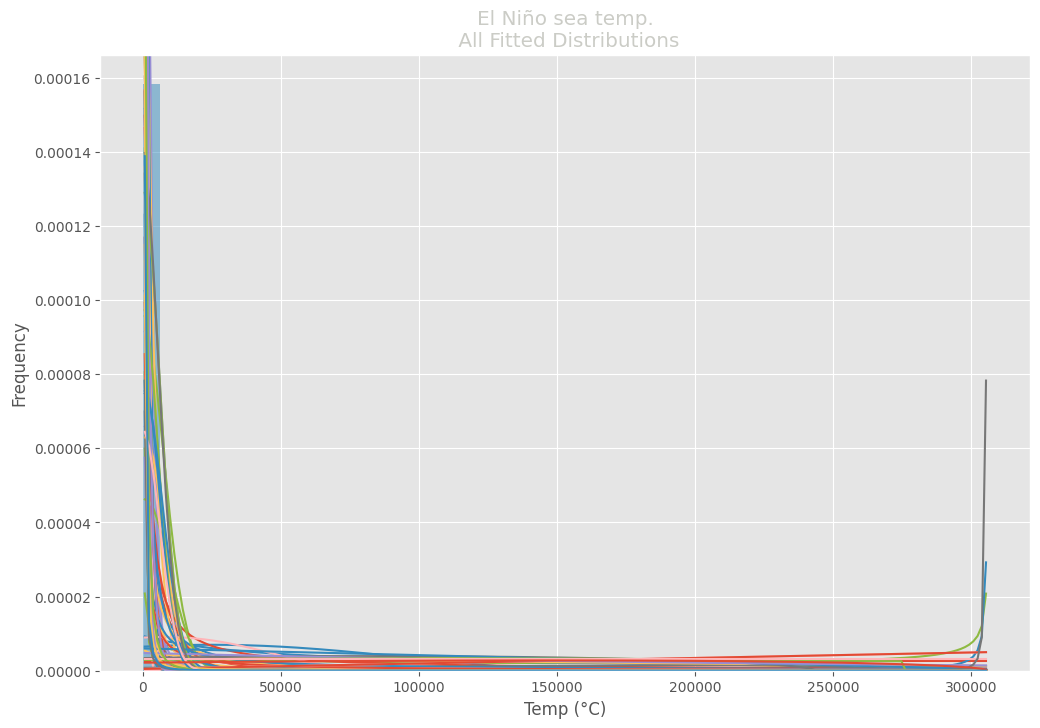

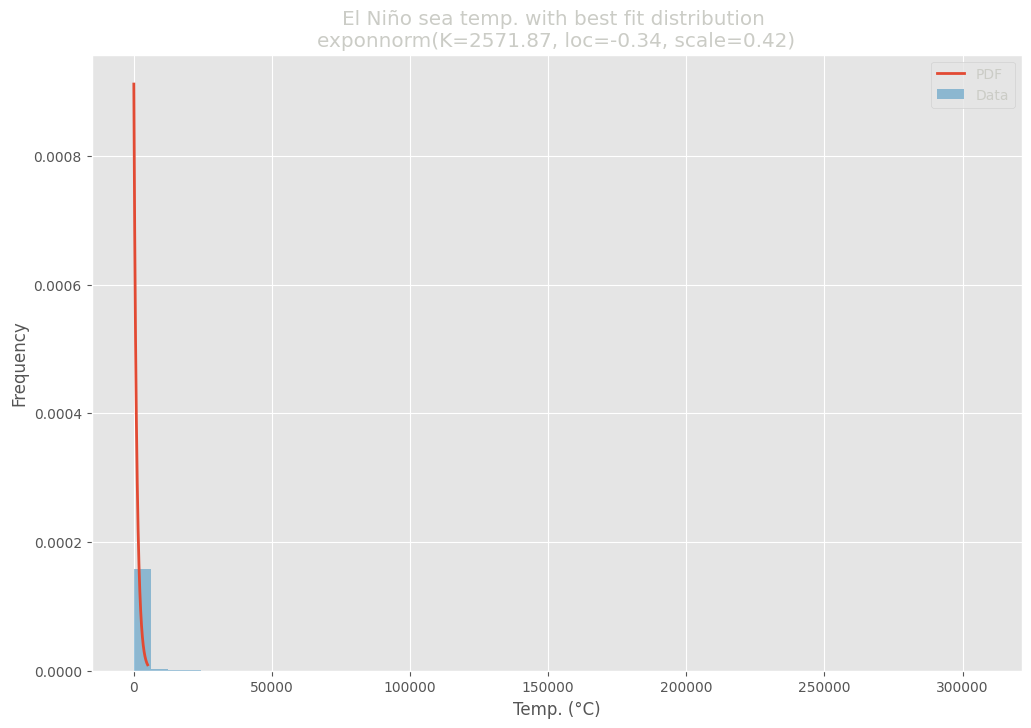

In [40]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (16.0, 12.0)
matplotlib.style.use("ggplot")


# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate(
        [d for d in _distn_names if not d in ["levy_stable", "studentized_range"]]
    ):
        print("{:>3} / {:<3}: {}".format(ii + 1, len(_distn_names), distribution))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass

    return sorted(best_distributions, key=lambda x: x[2])


def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function"""

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = (
        dist.ppf(0.01, *arg, loc=loc, scale=scale)
        if arg
        else dist.ppf(0.01, loc=loc, scale=scale)
    )
    end = (
        dist.ppf(0.99, *arg, loc=loc, scale=scale)
        if arg
        else dist.ppf(0.99, loc=loc, scale=scale)
    )

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


# Load data from statsmodels datasets
data = lognormal_dist

# Plot for comparison
plt.figure(figsize=(12, 8))
ax = data.plot(
    kind="hist",
    bins=50,
    density=True,
    alpha=0.5,
    color=list(matplotlib.rcParams["axes.prop_cycle"])[1]["color"],
)

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title("El Niño sea temp.\n All Fitted Distributions")
ax.set_xlabel("Temp (°C)")
ax.set_ylabel("Frequency")

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12, 8))
ax = pdf.plot(lw=2, label="PDF", legend=True)
data.plot(
    kind="hist", bins=50, density=True, alpha=0.5, label="Data", legend=True, ax=ax
)

param_names = (
    (best_dist[0].shapes + ", loc, scale").split(", ")
    if best_dist[0].shapes
    else ["loc", "scale"]
)
param_str = ", ".join(
    ["{}={:0.2f}".format(k, v) for k, v in zip(param_names, best_dist[1])]
)
dist_str = "{}({})".format(best_dist[0].name, param_str)

ax.set_title("El Niño sea temp. with best fit distribution \n" + dist_str)
ax.set_xlabel("Temp. (°C)")
ax.set_ylabel("Frequency")

In [53]:
pd.DataFrame(best_distibutions)[1][0]

(np.float64(2571.8708761995094),
 np.float64(-0.34457362737814856),
 np.float64(0.42225692785742064))

In [ ]:

exponnorm_gen

<Axes: >

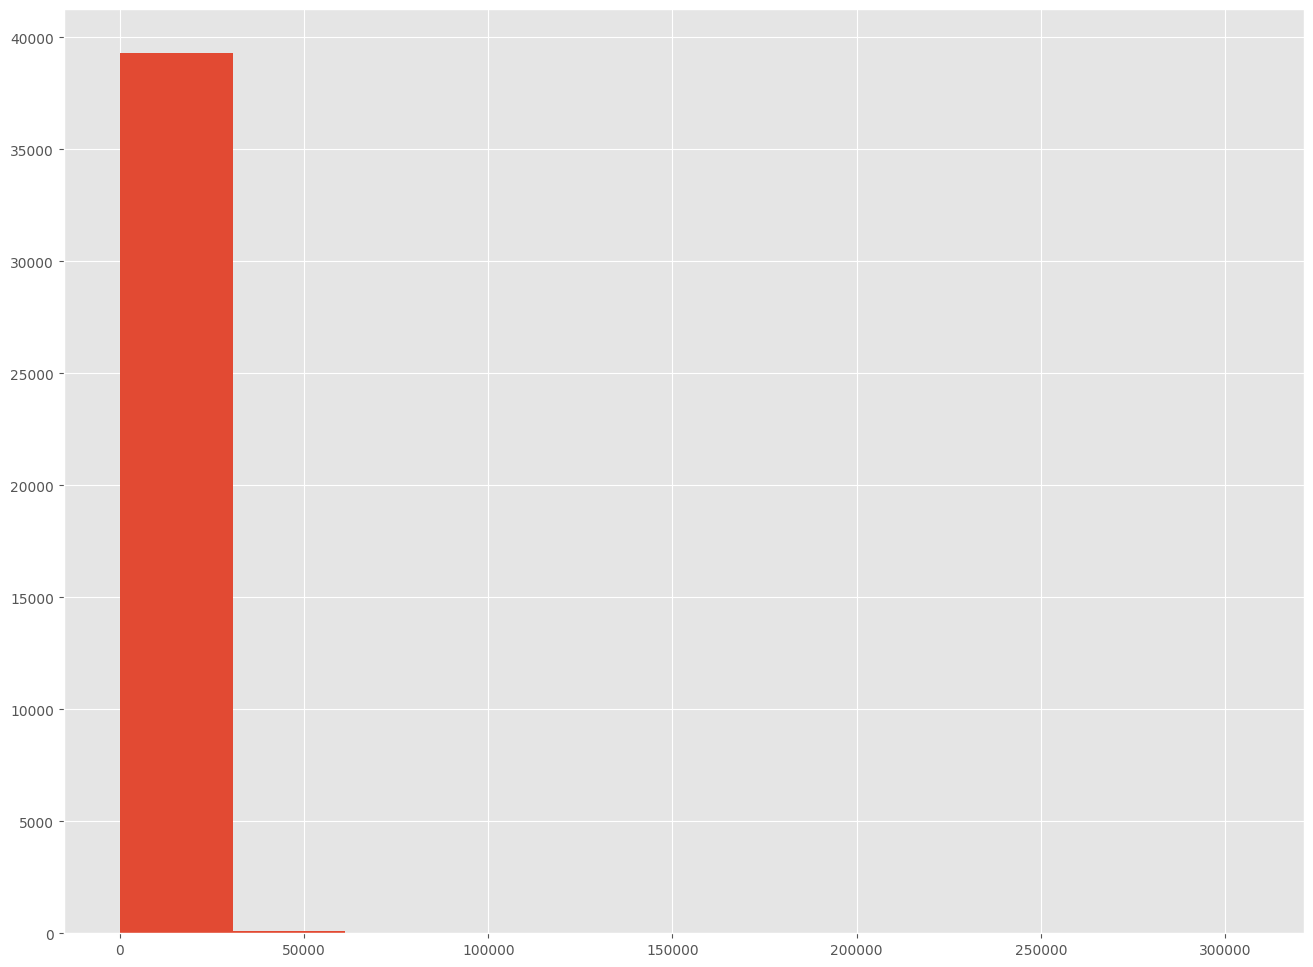

In [49]:
lognormal_dist.hist()